In [1]:
!pip install numpy==1.26.4 scipy==1.13.1 pmdarima==2.0.4 statsmodels==0.14.1 pandas==2.2.2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

### BANCO DE DADOS

---



In [5]:
caminho_arquivo = "VendasMensais.csv"
df = pd.read_csv(caminho_arquivo)
df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
91,01.08.2022,NaN,NaN,NaN,NaN
92,01.09.2022,NaN,NaN,NaN,NaN
93,01.10.2022,NaN,NaN,NaN,NaN
94,01.11.2022,NaN,NaN,NaN,NaN


### TRATAMENTO DE DADOS

---



In [6]:
data_col = 'Period'
sales_col = 'Revenue'

In [8]:
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df = df.sort_values('Period')

In [9]:
df.set_index(data_col, inplace=True)

In [10]:
df = df[df.index.year <= 2020]  # 2015 até 2020
df = df.dropna(subset=['Revenue'])  # Remove linha com valores ausentes

In [11]:
print("Início da série:", df.index.min())
print("Fim da série:", df.index.max())

Início da série: 2015-01-01 00:00:00
Fim da série: 2020-04-01 00:00:00


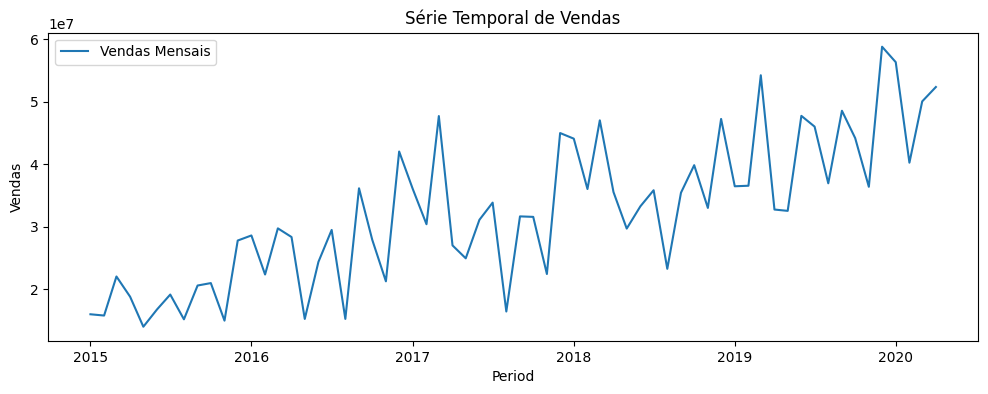

In [12]:
plt.figure(figsize=(12,4))
plt.plot(df[sales_col], label='Vendas Mensais')
plt.title('Série Temporal de Vendas')
plt.xlabel('Period')
plt.ylabel('Vendas')
plt.legend()
plt.show()

### TESTES ESTATÍSTICOS

---



In [13]:
df_cleaned = df.dropna(subset=[sales_col])

result = adfuller(df_cleaned[sales_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print("Série estacionária")
else:
    print("Série não estacionária - precisa diferenciar")

ADF Statistic: -0.269149
p-value: 0.929762
Série não estacionária - precisa diferenciar


### TREINAMENTO DO MODELO

---



In [14]:
p,d,q = 1,1,1
P,D,Q,m = 1,1,1,12  # sazonalidade mensal

In [15]:
model = SARIMAX(df['Revenue'], order=(p,d,q), seasonal_order=(P,D,Q,m))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   64
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -869.979
Date:                            Sat, 09 Aug 2025   AIC                           1749.958
Time:                                    17:36:09   BIC                           1759.617
Sample:                                01-01-2015   HQIC                          1753.649
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0241      0.288     -0.084      0.933      -0.589       0.541
ma.L1         -0.7192      0.219   

### PREVISÃO

---



In [16]:
#previsão próximos 12 meses
n_steps = 12
pred = model_fit.get_forecast(steps=n_steps)
pred_ci = pred.conf_int()

In [17]:
start_date = df.index.max() + pd.DateOffset(months=1)
forecast_index = pd.date_range(start=start_date, periods=12, freq='MS')
pred.predicted_mean.index = forecast_index
pred_ci.index = forecast_index

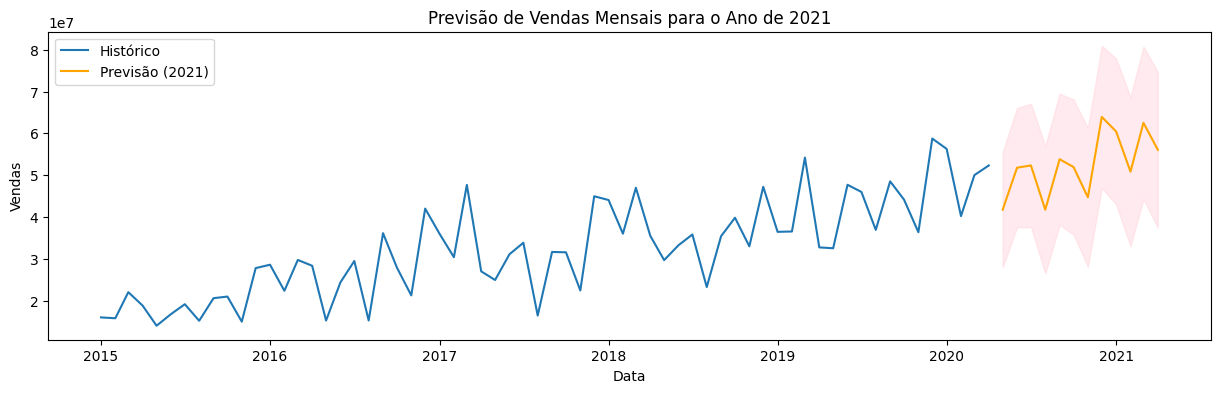

In [18]:
plt.figure(figsize=(15,4))
plt.plot(df['Revenue'], label='Histórico')
plt.plot(pred.predicted_mean, label='Previsão (2021)', color='orange')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Previsão de Vendas Mensais para o Ano de 2021')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()

### AUTO ARIMA

---



In [19]:
from pmdarima import auto_arima


modelo_auto = auto_arima(
    df['Revenue'],
    seasonal=True,
    m=12,  # sazonalidade mensal
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1773.932, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1776.074, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1775.883, Time=0.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1812.196, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1775.675, Time=0.26 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1775.248, Time=0.52 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1776.932, Time=0.48 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1775.386, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1775.307, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1777.435, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 4.230 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:       

### MODELO SIMPLIFICADO

---



In [20]:
model = SARIMAX(df['Revenue'],
                order=modelo_auto.order,
                seasonal_order=modelo_auto.seasonal_order)
model_fit = model.fit(disp=False)

In [21]:
n_steps = 12
pred = model_fit.get_forecast(steps=n_steps)
pred_ci = pred.conf_int()

In [22]:
start_date = df.index.max() + pd.DateOffset(months=1)
forecast_index = pd.date_range(start=start_date, periods=12, freq='MS')
pred.predicted_mean.index = forecast_index
pred_ci.index = forecast_index

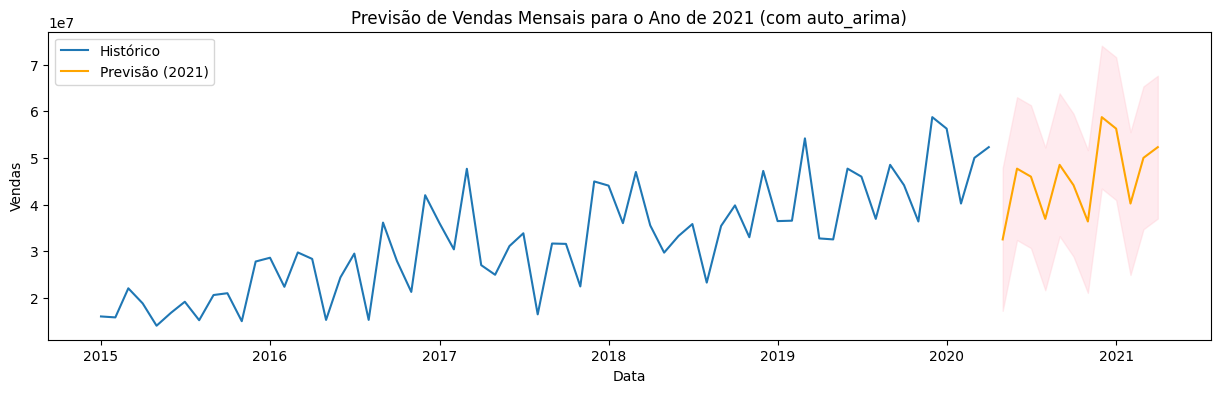

In [23]:
import matplotlib.dates as mdates

plt.figure(figsize=(15,4))
plt.plot(df['Revenue'], label='Histórico')
plt.plot(pred.predicted_mean, label='Previsão (2021)', color='orange')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Previsão de Vendas Mensais para o Ano de 2021 (com auto_arima)')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()
